<a href="https://colab.research.google.com/github/scigeek72/Bayesian_Hyperparameter_tunning/blob/main/Tune_XGBoost_classifier_with_Hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tunning hyper-parameters of a XGBoost classifier using Hyperopt package

The primary objective of this blog post is to highlight the critical role of hyperparameter tuning in the process of model building. Based on my experience in the field, particularly in the application domain, it is evident that there is often an emphasis on the power of algorithms or models, without giving adequate attention to the importance of fine-tuning them to achieve optimal performance. Through this post, I aim to emphasize the significance of hyperparameter tuning and encourage readers to prioritize this critical step in their machine learning workflows.

In this blog post, we will explore the use of the [Hyperopt package](https://github.com/hyperopt/hyperopt) for automatic hyperparameter tuning of a machine learning model. Specifically, we will use Hyperopt to tune a XGBoost classifier, although this methodology can also be applied to other types of classifiers or regressors. Hyperparameter tuning is a crucial step in machine learning, as it can significantly impact the performance of the model. While grid search and randomized search are commonly used optimization techniques, they have limitations such as being slow or underperforming. Bayesian optimization algorithms have emerged as a promising alternative to these traditional tuning algorithms. In this post, we will demonstrate how to use a Bayesian optimization algorithm provided by the Hyperopt package to optimize the hyperparameters of a XGBoost classifier for a classification task. We will begin by loading a dataset for classification.

## Loading dataset

We will load breast cancer data sets from scikit-learn.

In [ ]:
from sklearn import datasets

data = datasets.load_breast_cancer()

In [ ]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Below we will investigate the dataset to get an idea about it, e.g. what are the feature names, what is the target, and if any cleaning is needed.

In [ ]:
print(data['feature_names'])
print("\n**************************\n")
print(data['target_names'])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

**************************

['malignant' 'benign']


We will replace the space between words in `feature_names` by '_'. This is my personal taste and is not necessary if not desired.

In [ ]:
feature_names = [x.replace(' ','_') for x in data['feature_names'].tolist()] 

In [ ]:
X = data.data
y = data.target

print(f"Type of X is {type(X)}\n Type of y is {type(y)}")


Type of X is <class 'numpy.ndarray'>
 Type of y is <class 'numpy.ndarray'>


In [ ]:
# Convert the numpy arrays to pandas dataframe
import pandas as pd
import numpy as np

X = pd.DataFrame(X,columns = feature_names)
y = pd.DataFrame(y, columns = ['lable'])

In [ ]:
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64
 14  smoothness_error         5

Lets investigate the target column. 

In [ ]:
print(f"Number of cases labeled 1 is: {sum(y.lable == 1)}\n")

print(f"Number of cases labeled 0 is: {sum(y.lable == 0)}")

Number of cases labeled 1 is: 357

Number of cases labeled 0 is: 212


So, `Benign` is labeled as 1 and `Malignant` is labeled as 0

In [ ]:
nneg = sum(y.lable == 0)
npos = sum(y.lable == 1)

print(f"The ratio of negative to positive cases is: {nneg/npos}")

The ratio of negative to positive cases is: 0.5938375350140056


We will split the dataset into train and test sets. We will set aside test set and only use it to evaluate the model. 

Also, we will use `StratifiedShuffleSplit` to make sure the `train` and `test` sets has the same positive and negative cases.

In [ ]:
from pandas.core.common import random_state
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(2,test_size=0.2, random_state=44)
for tr_idx,ts_idx in ss.split(X,y):
  X_train, y_train = X.loc[tr_idx], y.loc[tr_idx]
  X_test, y_test = X.loc[ts_idx], y.loc[ts_idx]

print(f"\nShape of X_train is {X_train.shape}")
print(f"\nShape of X_test is {X_test.shape}")
print(f"\nLength of y_train is {y_train.shape}")
print(f"\nLength of y_test is {y_test.shape}")


Shape of X_train is (455, 30)

Shape of X_test is (114, 30)

Length of y_train is (455, 1)

Length of y_test is (114, 1)


In [ ]:
import xgboost as xgb
# Build DMatrix (primarily to make processing faster) 
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

Below we will cross-validate a model with default parameters. 

In [ ]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix,roc_auc_score

params_1 = {"objective": "binary:logistic"}

n = 1000

results = xgb.cv(params_1,
                 dtrain_clf,
                 num_boost_round = n,
                 nfold=5,
                 metrics = ["logloss","auc","error"],
                 early_stopping_rounds=20
                 )

In [ ]:
results.head()

,train-logloss-mean,train-logloss-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-logloss-mean,test-logloss-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.464040,0.004158,0.996691,0.002549,0.024176,0.008223,0.486575,0.010266,0.966609,0.026867,0.054945,0.028656
1,0.331266,0.002541,0.999291,0.000157,0.008242,0.003885,0.365231,0.013975,0.982045,0.014662,0.052747,0.027274
2,0.244992,0.002581,0.999695,0.000171,0.007692,0.004396,0.284250,0.016925,0.988781,0.010982,0.043956,0.023051
3,0.185390,0.002293,0.999820,0.000083,0.006044,0.002056,0.233371,0.022338,0.988673,0.011179,0.043956,0.024076
4,0.142205,0.002457,0.999887,0.000045,0.003297,0.001099,0.197808,0.027032,0.988299,0.011358,0.046154,0.022413


We asked `xgb.cv()` to track three metrics on the hold-out validation set. The `results` dataframe contains the values of these metrics on each split of the cross-validation. The column header is very informative. As you can see `test-auc-mean` is the column we will consider.

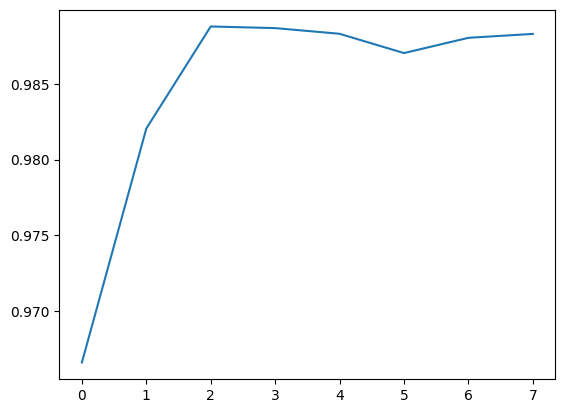

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results['test-auc-mean'])

We see that even for a model with only default parameters, the cross validated `auc` score reaches 0.985. This is pretty good. 

But the real test of the model lies when it is used to predict on the test set. 

`xgb.cv()` doesn't give a classifier object. So, next we will train a xgb classifier object on the entire training set and then test it.

In [ ]:
clf_1 = xgb.XGBClassifier(**params_1)

clf_1.fit(X_train,y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
pred_1 = clf_1.predict(X_test)

In [ ]:
print(f"f1 score : {f1_score(y_test, pred_1)}\n")
print(f"confusion Matrix\n: {confusion_matrix(y_test, pred_1)}\n")
print(f"auc score: {roc_auc_score(y_test, pred_1)}")


f1 score : 0.9600000000000001

confusion Matrix
: [[36  6]
 [ 0 72]]

auc score: 0.9285714285714286


On the held out test set, we hit a f1_score of .96 which is pretty good, particularly when we are basically using the default parameters. Now the question is can we improve it? 

A google search would reveal several posts which talks about tunning the hyper-parameters of this model. However, since `XGBClassifier` (and `XGBRegressor`) has so many hyper-parameters available, it is initially hard to pick and choose. This choice obviously depends on the data. 

Since we don't have any apriory knowledge about it, we will "go full monty" and tune all the hyper-parameters that are available to us. 



# A brief over view of the optimization procedure

In this blog post, we will explore the use of the [Hyperopt library](https://github.com/hyperopt/hyperopt) to optimize an XGBoost classifier. Hyperopt utilizes Bayesian optimization techniques to solve the hyperparameter optimization problem. To use Hyperopt, users must provide a "search space" for the hyperparameters they wish to optimize in order to find the best classifier performance. Hyperopt then builds a probabilistic model based on this search space, selecting random points and creating a "good" and a "bad" region of the space depending on the performance of the machine learning model. It then constructs a joint probability distribution over these regions, sampling points from the space to evaluate the machine learning model. This process is repeated multiple times until some stopping condition is reached, using the Tree-Structured Parzen estimator algorithm.  Interested readers can look at [Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures](http://proceedings.mlr.press/v28/bergstra13.pdf) and the references therein for a more thorough understanding.

To use Hyperopt, we require a search space (user-defined), an objective function, and the use of the fmin() function to minimize the objective function over the search space. Hyperopt uses a Trials object to keep track of all the results of the experiments.

 - The **search space** defines all the parameters we want to optimize, along with their range and the probability distributions (if desired) that we think the algorithm should sample from during optimization. Hyperopt defines these distributions in the hp object.

 - In the **objective function**, we define the machine learning algorithm we are interested in (in our case, the XGBoost classifier), along with an evaluation metric that the fmin() function uses during optimization to keep track of the performance. If the evaluation metric is something like F1 score, it should be multiplied by (-1) for minimization.

 - The `fmin()` function is the engine that drives the optimization process. The minimum set of arguments required for this function are the search space, objective function, Trials object, the algorithm to use (TPE, for example), and the maximum number of iterations (max_eval). An early stopping criterion can also be defined. If users want the values where the minimum value is reached given the search criterion, they should set the `return_argmin` argument to `False`; otherwise, it will return the position (in the array) where the minimum value is attained.


It is important to note that this procedure returns a set of hyperparameter values that it thinks optimize the machine learning model given the search space and the data. We must use these values to define the model again on the training set. Furthermore, it is recommended to run a cross-validation procedure inside the objective function rather than utilizing the test set to learn the optimal hyperparameters.





## Full set of parameters

Below is the search space with **most** of the tunable parameters included. We are utilizing `hyperopt` library to tune our parameters. There are other packages available, for example, `scikit-opt` etc that utilizes a different optimization engine than hyperopt. 



In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss

In [ ]:
search_space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : hp.uniform("gamma", 0, 10e1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5,1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'max_delta_step' : hp.choice("max_delta_step", np.arange(1,10,1,dtype='int')),
    'subsample' : hp.uniform("subsample",0.5,1),
    'objective' : 'binary:logistic',
    'eval_metric' : 'aucpr',
    #'scale_pos_weight' : hp.uniform('scale_pos_weight', np.ceil(nneg/npos - 2), np.ceil(nneg/npos + 10)),
    'seed' : 44
}

Now that we have defined a search space for **xgbClassifier**, we will go ahead and define the objective function. 

Note, I will define it in 3 slightly different ways but utilize the last one as I like it over the rest as it utilizes xgboost's `cv()` function. Though for our toy example we could have used the other functions, for large datasets would significantly improve performance. 

Also note that the objective function should return a dictionary with `loss` and `status` keys **must** be included in the dictorary. There are some other keys that you can include as well (see the hyperopt documentation referenced above) but to keep things simple, we use the bare minimum that is needed for the hyperopt to work. 

Hyperopt minimizes the objective function by monitoring the loss function. So if the evaluation metric used is something that is needed to be maximized, then it needs to be multiplied by (-1) as is done below ( maximizing a quantity is same as minimizing the negative of that quantity). 

In [ ]:

def objective(space):
  clf = xgb.XGBRFClassifier(**space)
  evaluation = [(X_train, y_train),(X_test, y_test)]
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  f1_ = f1_score(y_test, pred)
  return {'loss': -f1_, 'status': STATUS_OK}


def new_objective(space):
  clf = xgb.XGBClassifier(**space)
  cv_score = cross_val_score(estimator=clf, X = X_train, y=y_train, cv=5, scoring='f1')
  f1_ = np.mean(cv_score)
  return {'loss':-f1_, 'status':STATUS_OK}

def xgb_objective(space):
  results = xgb.cv(space, dtrain=dtrain_clf, num_boost_round=500, nfold=5, stratified=True, early_stopping_rounds=20,
                   metrics = ['logloss','auc','aucpr','error'])
  
  best_score = results['test-auc-mean'].max()
  return {'loss':-best_score, 'status': STATUS_OK}

Now that we have already defined the objective function, we will go ahead and get the best parameters using the `fmin` function of the hyperopt package. 

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn=xgb_objective, space=search_space,algo=tpe.suggest,max_evals=500,trials=trials, return_argmin=False, early_stop_fn=no_progress_loss(10))

best_params = best_hyperparams.copy()

if 'eval_metric' in best_params:
  best_params = {key:best_params[key] for key in best_params if key!='eval_metric'}

best_params

We have obtained a set of best parameters. Now we will build the classifier and test on the test set. 

In [ ]:
clf_2 = xgb.XGBClassifier(**best_params)
clf_2.fit(X_train, y_train)

pred_2 = clf_2.predict(X_test)

print(f"f1 score : {f1_score(y_test, pred_2)}\n")
print(f"confusion Matrix\n: {confusion_matrix(y_test, pred_2)}\n")
print(f"auc score: {roc_auc_score(y_test, pred_2)}")


f1 score : 0.9403973509933775

confusion Matrix
: [[34  8]
 [ 1 71]]

auc score: 0.8978174603174603


Oppss!!! Note that our performance dropped compared to default parameters where the f1 score was 0.960. But why? Afterall, we optimized the parameters and during optimization only used cross-validation on the training set to keep information leakage from test set into our model. 

Then why is the performance drop? This shows that with all these hyperparameters tuned based on the training set, the model learned **too much** of the training set and failed to generalize. A classic case of **overfitting** happening right infront of our eyes. 

One possible reason, could be the number of hyperparameters we chose to tune. It seems that since we tuned all possible tunable parameters, it may have backfired. 

At this point, redo the above experiments by removing one hyper-parmeters at a time and see if that imroves the f1 score above the default score.

After playing around with the hyper-parameters and their ranges, I hit upon the the following search space.

Lets see how we do.

In [ ]:
search_space_3 = {
    #'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'eta'      : hp.uniform("eta", 0, 1),
    'gamma'    : 0,#hp.uniform("gamma", 0, 1),
    #'reg_alpha': hp.uniform("reg_alpha", 10e-7, 1),
    'reg_lambda' : hp.uniform("reg_lambda", 0,1),
    'n_estimators': hp.choice("n_estimators", np.arange(100,1000,10,dtype='int')),
    #'min_child_weight' : hp.choice("min_child_weight", np.arange(1,10,1,dtype='int')),
    'objective' : 'binary:logistic',
    'eval_metric' : 'auc',
    #'scale_pos_weight' : hp.uniform('scale_pos_weight', np.ceil(nneg/npos - 2), np.ceil(nneg/npos + 10)),
    'seed' : 44
}

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn=xgb_objective, 
                        space=search_space_3,
                        algo=tpe.suggest, 
                        max_evals=500,
                        trials=trials, 
                        return_argmin=False, 
                        early_stop_fn=no_progress_loss(10))

best_params_3 = best_hyperparams.copy()

if 'eval_metric' in best_params_3:
  best_params_3 = {key:best_params_3[key] for key in best_params_3 if key!='eval_metric'}

best_params_3

In [ ]:
clf_3 = xgb.XGBClassifier(**best_params_3)
clf_3.fit(X_train, y_train)

pred_3 = clf_3.predict(X_test)

print(f"f1 score : {f1_score(y_test, pred_3)}\n")
print(f"confusion Matrix\n: {confusion_matrix(y_test, pred_3)}\n")
print(f"auc score: {roc_auc_score(y_test, pred_3)}")


f1 score : 0.9664429530201343

confusion Matrix
: [[37  5]
 [ 0 72]]

auc score: 0.9404761904761905


Notice, with this combination of hyper-parameters and their values, f1 score exceeds the f1 score with default hyper-parameters. Also note the value of the hyper-parameter `gamma` ( γ ). It is set to 0. γ is an important hyper-parameter for xgboost. A good blog post about tunning hyper-parameters and a discussion of the effect of γ on the model can be found in this medium article [here](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6). 

# Conclusion

In conclusion, the process of tuning hyperparameters for a XGBoost classifier can be a daunting task with so many different tunable hyper-parameter available to the user. As demonstrated in this post, Bayesian optimization algorithms provided by the Hyperopt package offer a promising alternative to traditional tuning algorithms such as grid search or randomized search. By following the example and guidelines provided in this post, we hope that readers will gain a better understanding of the process of hyperparameter tuning and be able to optimize their XGBoost classifiers effectively.

As stated in the begining of this article, the primary focus of this post is to highlight the importance of hyperparameter tuning for all machine learning models (and not just for xgboost classifier). I hope that readers will find this information useful and will be able to adopt it in their own work to optimize the performance of their machine learning models. 